# ALPR++

In [58]:
from typing import Any
import os
import glob
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
from IPython.display import Image, display, HTML
import pandas as pd
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.exceptions import OutputParserException
from langchain_core.runnables import chain
from dotenv import load_dotenv

load_dotenv()

True

In [40]:
def image_encoding(inputs):
    with open(inputs["image_path"], "rb") as image_file:
        image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    return {"image": image_base64}

In [41]:
class Vehicle(BaseModel):
    type: str = Field(..., examples=["Car", "Truck", "Motorcycle", "Bus"], description="Return the type of the vehicle")
    license_plate: str = Field(..., description="Return the license plate number of the vehicle")
    make: str = Field(..., examples=["Toyota", "Honda", "Ford", "Suzuki"], description="Return the Make of the vehicle")
    model: str = Field(..., examples=["Corolla", "Civic", "F-150"], description="Return the model of the vehicle")
    color: str = Field(..., examples=["Red", "Blue", "Black", "White"], description="Return the color of the vehicle")

In [59]:
parser = JsonOutputParser(pydantic_object = Vehicle)
instructions = parser.get_format_instructions()
instructions

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"type": {"title": "Type", "description": "Return the type of the vehicle", "examples": ["Car", "Truck", "Motorcycle", "Bus"], "type": "string"}, "license_plate": {"title": "License Plate", "description": "Return the license plate number of the vehicle", "type": "string"}, "make": {"title": "Make", "description": "Return the Make of the vehicle", "examples": ["Toyota", "Honda", "Ford", "Suzuki"], "type": "string"}, "model": {"title": "Model", "description": "Return the model of the vehicle", "examples": ["Corolla", "Civi

In [60]:
@chain
def prompt(inputs):
    prompt = [
    SystemMessage(content="""You are an AI assistant whose job is to inspect an image and provide the desired information from the image. If the desired field is not clear or not well detected, return None for this field. Do not try to guess."""),
    HumanMessage(
        content=[
            {"type": "text", "text": """Examine the main vehicle type, license plate number, make, model and color."""},
            {"type": "text", "text": instructions},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{inputs['image']}", "detail": "low", }}]
        )
    ]
    return prompt

In [61]:
@chain
def generate(inputs):
    model: ChatOpenAI = ChatOpenAI(
        model="gpt-4o",
        temperature=0.0,
        max_tokens=512,
    )
    output = model.invoke(inputs)
    return output.content

In [62]:
pipeline = image_encoding | prompt | generate | parser

In [63]:
pipeline

RunnableLambda(image_encoding)
| RunnableLambda(prompt)
| RunnableLambda(generate)
| JsonOutputParser(pydantic_object=<class '__main__.Vehicle'>)

In [64]:
img_path = "image.jpeg"

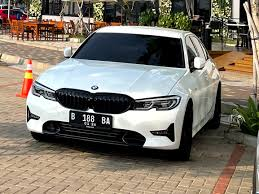

In [65]:
display(Image(img_path))

In [66]:
output = pipeline.invoke({"image_path": f"{img_path}"})
output

{'type': 'Car',
 'license_plate': 'B 188 BA',
 'make': 'BMW',
 'model': '3 Series',
 'color': 'White'}